### Домашнее задание к лекции 6

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [227]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import model_selection
import numpy as np
from tqdm import tqdm
import random

In [228]:
from sklearn.datasets import load_diabetes

In [229]:
X, y = load_diabetes(return_X_y=True)

In [230]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [231]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [232]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [233]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [234]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [235]:
def evaluate_alg(max_depth, X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {len(trees)} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [236]:
def get_error_plot(depth_tree_set):
    plt.figure(figsize=(15, 10))
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    for i in range(len(depth_tree_set)):
        depth = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]
    
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'train error, depth {depth}')
        plt.plot(list(range(n_trees)), test_err, label=f'test error, depth {depth}')
        
    plt.legend(loc='upper right')
    plt.show()

In [237]:
def n_trees_depth(n_trees_max, max_depth, eta = 0.1):
    coefs = [1] * n_trees_max
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = gb_fit(n_trees_max, d, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

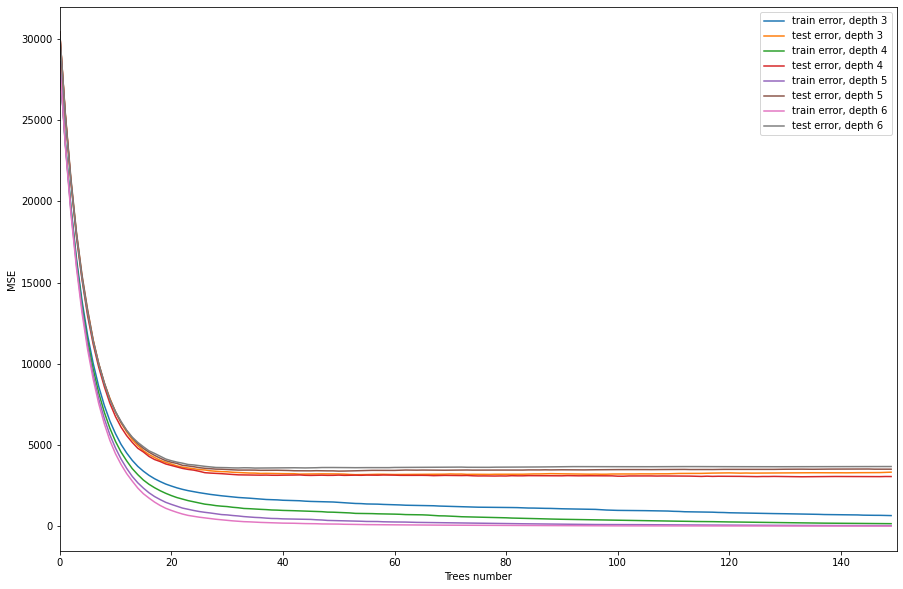

In [243]:
n_trees_max = 150
max_depth =  np.arange(start=3, stop=7, step=1)
sets = n_trees_depth(n_trees_max, max_depth)

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [258]:
def get_bootstrap(data, labels, N, size):
    n_samples = int(size * data.shape[0])
    bootstrap = []

    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
  

    return bootstrap

In [250]:
def gb_fit_sgb(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    bootstrap = get_bootstrap(X_train, y_train, n_trees, 0.5)
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        b_X_train, b_y_train = bootstrap[i]   
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(b_X_train, b_y_train)
            
            train_errors.append(mean_squared_error(b_y_train, gb_predict(b_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(b_X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(b_y_train, target))
            
            train_errors.append(mean_squared_error(b_y_train, gb_predict(b_X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [251]:
def n_trees_depth_sgb(n_trees_max, max_depth, eta = 0.1):
    coefs = [1] * n_trees_max
    depth_tree_set = []
    for d in max_depth:
        trees, train_errors, test_errors = gb_fit_sgb(n_trees_max, d, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_set.append([d, trees, train_errors, test_errors])
    get_error_plot(depth_tree_set)
    return depth_tree_set

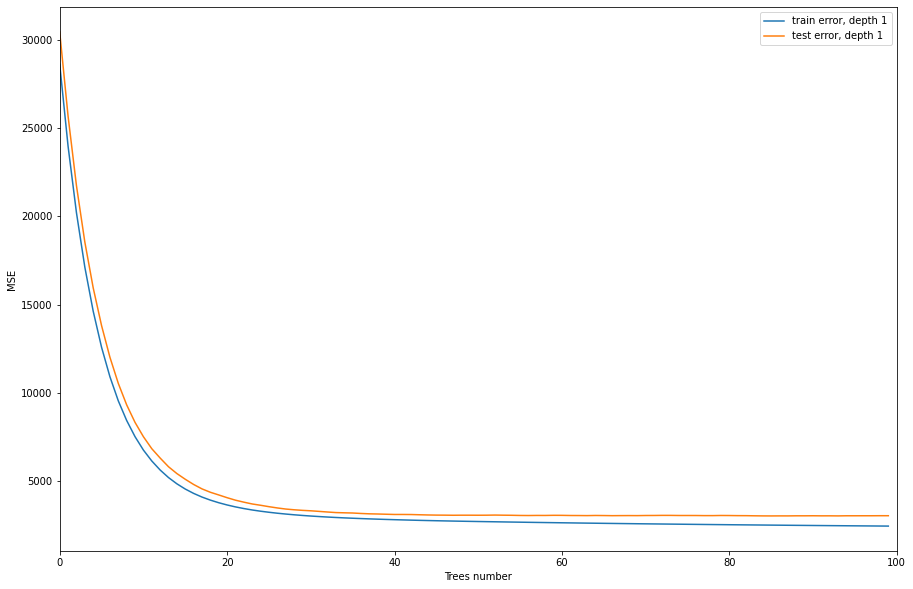

In [252]:
n_trees_max = 100
max_depth =  np.arange(start=1, stop=2, step=1)
sets = n_trees_depth(n_trees_max, max_depth)

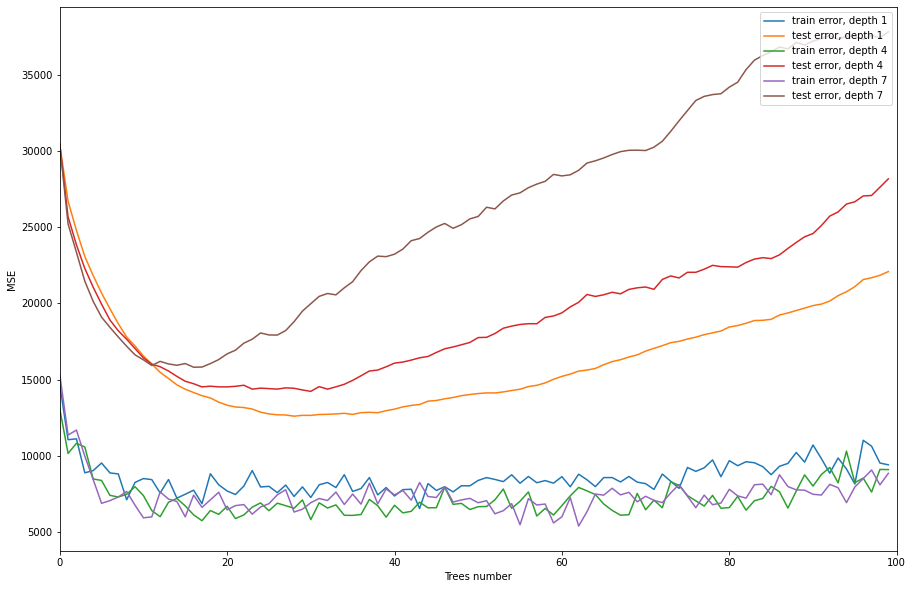

In [260]:
n_trees_max = 100
max_depth =  np.arange(start=1, stop=10, step=3)
sets = n_trees_depth_sgb(n_trees_max, max_depth)

Вывод: результаты применения алгоритма бустинга лучше чем градиентного бустинга. С увеличением глубины деревьев, растет ошибка на тесте, хот я на трейне наоборот ошибка уменьшается